## Set-up

In [1]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
from SAMImgEncoder import SAMImgEncoder

import onnxruntime
# print cuda is available or not
print(torch.cuda.is_available())

print(onnxruntime.get_available_providers())

c:\Users\12192\anaconda3\envs\python3_10\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


True
['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']


In [2]:
def show_mask(mask, ax):
    color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))   

## Example Image

In [3]:
image = cv2.imread('images/truck.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(image.shape)
print(image.flatten()[:100])

(1200, 1800, 3)
[ 67  48  54  57  42  47  51  45  47 150 152 151 141 152 148 137 154 148
 138 154 151 141 157 154 134 149 146 140 150 149 144 152 154 144 152 154
 143 151 153 140 152 152 138 152 153 138 154 154 141 153 153 140 152 152
 141 153 153 144 156 156 147 159 159 148 160 160 144 156 156 141 153 153
 147 159 159 144 156 156 140 152 152 137 149 149 136 148 148 139 151 151
 143 155 155 145 157 157 137 148 150 139]


In [4]:
onnx_model_quantized_path = "../savedmodel/sam_onnx_example.onnx"
ort_session = onnxruntime.InferenceSession(onnx_model_quantized_path,
                                           providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])


In [5]:
encoder = SAMImgEncoder('../config.json') # here load a onnx img-encoder
encoded_img = encoder.encode_img(image) # 1m 8.5s

PIL:  [ 62  45  51  81  75  77 143 153 149 137 153 149 136 152 149 139 150 149
 143 151 153 140 151 152 138 152 152 140 153 153 141 153 153 145 157 157
 144 156 156 141 153 153 142 154 154 138 150 150 138 150 150 142 154 154
 139 151 152 141 152 154 139 150 152 137 148 150 137 148 150 135 146 148
 136 147 149 136 147 149 138 149 151 139 150 152 133 144 146 133 144 146
 137 148 150 141 152 154 137 148 150 137]
cv2:  [ 63  45  51  65  60  62 143 153 149 137 153 149 137 153 149 140 150 149
 144 151 153 140 151 152 138 152 153 141 153 153 141 153 153 145 157 157
 145 157 157 141 153 153 143 155 155 137 149 149 137 149 149 143 155 155
 137 148 150 141 152 154 139 150 152 136 147 149 138 149 151 134 146 147
 135 146 148 137 148 150 139 150 152 140 151 153 134 145 147 132 143 145
 138 149 151 142 153 155 136 147 149 137]
transformed_image: tensor([ 62,  81, 143, 137, 136, 139, 143, 140, 138, 140, 141, 145, 144, 141,
        142, 138, 138, 142, 139, 141, 139, 137, 137, 135, 136, 136, 138, 139,

In [6]:
print(encoded_img[0].flatten()[:100])

[-0.05394331 -0.1366498  -0.07519287 -0.03739563 -0.00294694  0.03361887
  0.0749791   0.03927195  0.04487577  0.06193794  0.12228769  0.12796527
  0.15116327  0.20903586  0.01974037  0.07460125  0.02473293 -0.07497378
  0.07873617  0.20165212  0.0147936   0.08388354  0.07269363  0.15430397
  0.08962576  0.00052792  0.19066651 -0.03405396 -0.09472968 -0.07964338
  0.06337029  0.04191711 -0.06712535  0.07429977  0.05915895  0.05932253
  0.07888003  0.0138752   0.06573807  0.09288153  0.1181657   0.18632746
 -0.03825808 -0.04461097 -0.04597707 -0.03032462 -0.00874665 -0.0123713
 -0.00194765  0.00367398  0.01395057  0.02076309  0.01921693  0.03298881
  0.04509225  0.07529214  0.07811698  0.03759874  0.05939106  0.08396339
  0.09419721 -0.02237075 -0.13365285 -0.10393322 -0.0786546  -0.03394474
  0.00226356  0.01134322  0.02837264  0.06885905  0.09648079  0.04533504
  0.00971785  0.02809486  0.06105439  0.09935409  0.13330053  0.06846164
 -0.16023044 -0.2106027  -0.15460908 -0.15588616 -0.

In [7]:
image_embedding = encoded_img
print(image_embedding.shape)

(1, 256, 64, 64)


### Example point input

In [9]:
input_point = np.array([[500, 375]])
input_label = np.array([1])

onnx_coord = np.concatenate([input_point, np.array([[0.0, 0.0]])], axis=0)[None, :, :]
onnx_label = np.concatenate([input_label, np.array([-1])], axis=0)[None, :].astype(np.float32)

onnx_coord = encoder.apply_coords(onnx_coord, image.shape[:2]).astype(np.float32)
print(onnx_coord,'\n',onnx_coord.shape,'\n',onnx_coord.flatten())

[[[284.44446 213.4375 ]
  [  0.        0.     ]]] 
 (1, 2, 2) 
 [284.44446 213.4375    0.        0.     ]


In [11]:
onnx_label.shape

(1, 2)

In [12]:
np.array(image.shape[:2], dtype=np.float32)

array([1200., 1800.], dtype=float32)

Create an empty mask input and an indicator for no mask.

In [8]:
onnx_mask_input = np.zeros((1, 1, 256, 256), dtype=np.float32)
onnx_has_mask_input = np.zeros(1, dtype=np.float32)

Package the inputs to run in the onnx model

In [9]:
ort_inputs = {
    "image_embeddings": image_embedding,
    "point_coords": onnx_coord,
    "point_labels": onnx_label,
    "mask_input": onnx_mask_input,
    "has_mask_input": onnx_has_mask_input,
    "orig_im_size": np.array(image.shape[:2], dtype=np.float32)
}

In [18]:
np.array(image.shape[:2], dtype=np.float32).shape

(2,)

Predict a mask and threshold it.

In [10]:
masks, _, low_res_logits = ort_session.run(None, ort_inputs)
mask_threshold = 0.0
masks = masks > mask_threshold

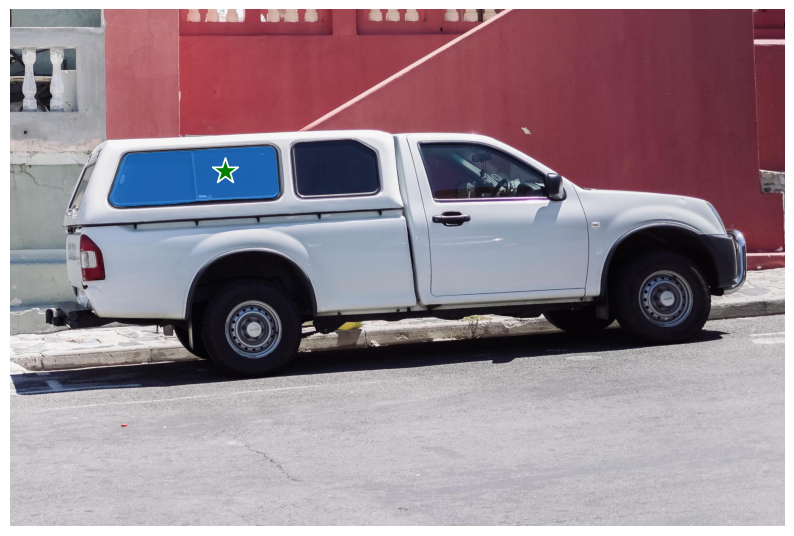

In [11]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

### Example mask input

In [12]:
input_point = np.array([[500, 375], [1125, 625]])
input_label = np.array([1, 1])

# Use the mask output from the previous run. It is already in the correct form for input to the ONNX model.
onnx_mask_input = low_res_logits

In [13]:
onnx_coord = np.concatenate([input_point, np.array([[0.0, 0.0]])], axis=0)[None, :, :]
onnx_label = np.concatenate([input_label, np.array([-1])], axis=0)[None, :].astype(np.float32)

onnx_coord = encoder.apply_coords(onnx_coord, image.shape[:2]).astype(np.float32)

The `has_mask_input` indicator is now 1.

In [14]:
onnx_has_mask_input = np.ones(1, dtype=np.float32)

Package inputs, then predict and threshold the mask.

In [15]:
ort_inputs = {
    "image_embeddings": image_embedding,
    "point_coords": onnx_coord,
    "point_labels": onnx_label,
    "mask_input": onnx_mask_input,
    "has_mask_input": onnx_has_mask_input,
    "orig_im_size": np.array(image.shape[:2], dtype=np.float32)
}

masks, _, _ = ort_session.run(None, ort_inputs)
masks = masks > 0.0

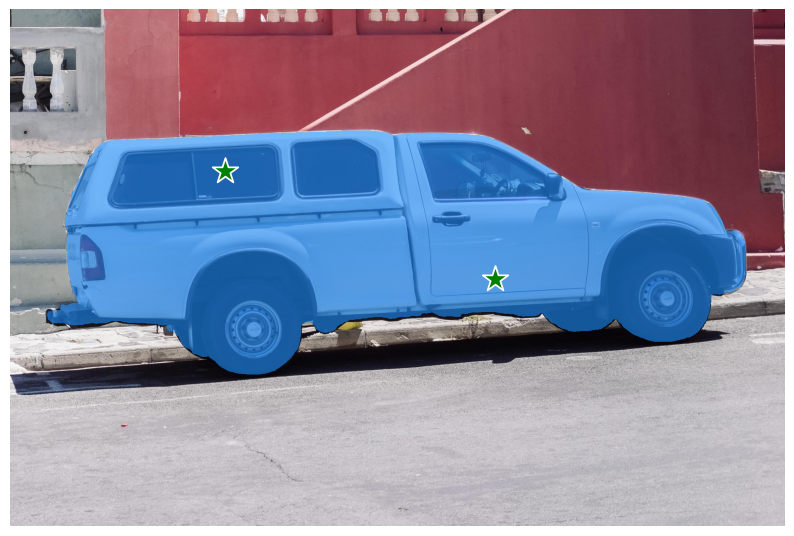

In [16]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

2 points with diff label

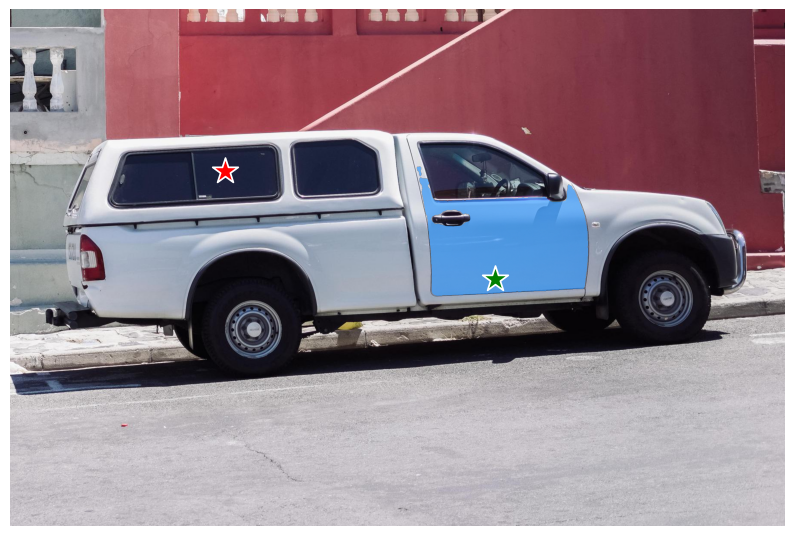

In [18]:
input_point = np.array([[500, 375], [1125, 625]])
input_label = np.array([0, 1])

# Use the mask output from the previous run. It is already in the correct form for input to the ONNX model.
onnx_mask_input = low_res_logits

onnx_coord = np.concatenate([input_point, np.array([[0.0, 0.0]])], axis=0)[None, :, :]
onnx_label = np.concatenate([input_label, np.array([-1])], axis=0)[None, :].astype(np.float32)

onnx_coord = encoder.apply_coords(onnx_coord, image.shape[:2]).astype(np.float32)

onnx_has_mask_input = np.ones(1, dtype=np.float32)

ort_inputs = {
    "image_embeddings": image_embedding,
    "point_coords": onnx_coord,
    "point_labels": onnx_label,
    "mask_input": onnx_mask_input,
    "has_mask_input": onnx_has_mask_input,
    "orig_im_size": np.array(image.shape[:2], dtype=np.float32)
}

masks, _, _ = ort_session.run(None, ort_inputs)
masks = masks > 0.0

plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

### Example box and point input

In [19]:
input_box = np.array([425, 600, 700, 875])
input_point = np.array([[575, 750]])
input_label = np.array([0])

Add a batch index, concatenate a box and point inputs, add the appropriate labels for the box corners, and transform. There is no padding point since the input includes a box input.

In [21]:
onnx_box_coords = input_box.reshape(2, 2)
onnx_box_labels = np.array([2,3])

onnx_coord = np.concatenate([input_point, onnx_box_coords], axis=0)[None, :, :]
onnx_label = np.concatenate([input_label, onnx_box_labels], axis=0)[None, :].astype(np.float32)

onnx_coord = encoder.apply_coords(onnx_coord, image.shape[:2]).astype(np.float32)

Package inputs, then predict and threshold the mask.

In [22]:
onnx_mask_input = np.zeros((1, 1, 256, 256), dtype=np.float32)
onnx_has_mask_input = np.zeros(1, dtype=np.float32)

ort_inputs = {
    "image_embeddings": image_embedding,
    "point_coords": onnx_coord,
    "point_labels": onnx_label,
    "mask_input": onnx_mask_input,
    "has_mask_input": onnx_has_mask_input,
    "orig_im_size": np.array(image.shape[:2], dtype=np.float32)
}

masks, _, _ = ort_session.run(None, ort_inputs)
masks = masks > 0.0

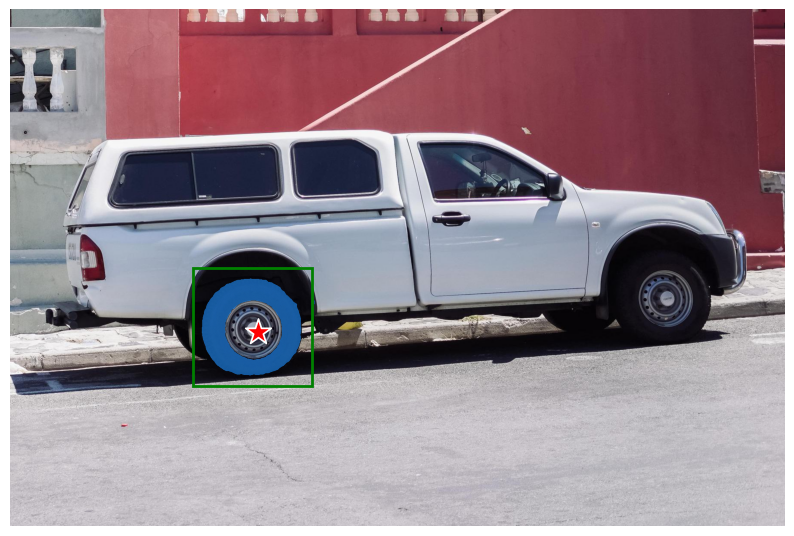

In [23]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()